In [ ]:
# !pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ecg_adult
!unzip /content/drive/MyDrive/MAIC/ecg_adult_train.zip -d ecg_adult

In [ ]:
!mkdir ecg_child
!unzip /content/drive/MyDrive/MAIC/ECG_child_numpy_train.zip -d ecg_child

In [ ]:
adult = pd.read_csv('/content/drive/MyDrive/MAIC/ECG_adult_age_train.csv')
child = pd.read_csv('/content/drive/MyDrive/MAIC/ECG_child_age_train.csv')

In [ ]:
adult.GENDER.value_counts()

FEMALE     18096
MALE       16787
unknown       24
Name: GENDER, dtype: int64

In [ ]:
adult.isnull().sum(1).sum()

0

In [ ]:
child.GENDER.value_counts()

MALE       4854
FEMALE     3926
unknown       1
Name: GENDER, dtype: int64

In [ ]:
child.isnull().sum(1).sum()

0

In [ ]:
child.AGE.describe()

count    8781.000000
mean        2.168157
std         1.944972
min         0.083333
25%         0.583333
50%         1.250000
75%         3.750000
max         8.083333
Name: AGE, dtype: float64

In [ ]:
import random

In [ ]:
adult['type'] = 'Adult'
child['type'] = 'Child'

In [ ]:
train = pd.concat([adult, child])

In [ ]:
train = train[train['GENDER']!='unknown'].reset_index(drop  = True)

In [ ]:
test_ix = random.sample(train.index.tolist(),int(len(train)*0.1))

In [ ]:
test = train[train.index.isin(test_ix)].reset_index()
train = train[~train.index.isin(test_ix)].reset_index()

In [ ]:
test.AGE

0       68.000000
1       89.000000
2       79.000000
3       65.000000
4       77.000000
          ...    
4361     1.166667
4362     1.833333
4363     7.000000
4364     0.583333
4365     5.833333
Name: AGE, Length: 4366, dtype: float64

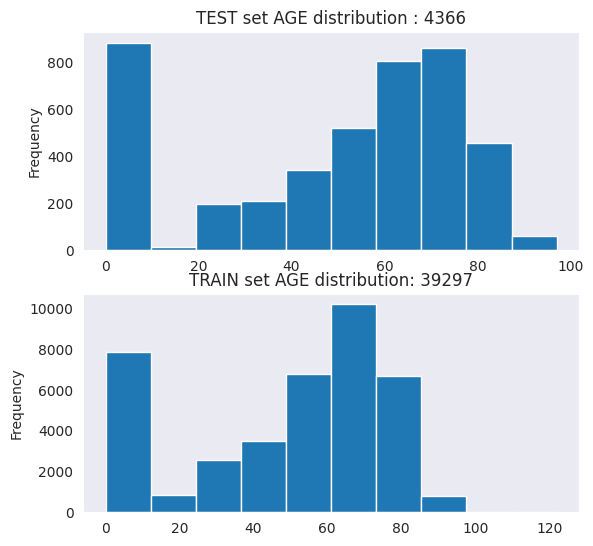

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax = test.AGE.plot.hist()
ax.set_title(f'TEST set AGE distribution : {len(test)}')

ax = fig.add_subplot(2,1,2)
ax = train.AGE.plot.hist()
ax.set_title(f'TRAIN set AGE distribution: {len(train)}')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

In [ ]:
train.head()

,index,FILENAME,GENDER,AGE,type
0,0,ecg_adult_0,MALE,53.0,Adult
1,1,ecg_adult_1,MALE,68.0,Adult
2,5,ecg_adult_5,FEMALE,59.0,Adult
3,6,ecg_adult_6,MALE,79.0,Adult
4,7,ecg_adult_7,MALE,83.0,Adult


In [ ]:
# !mkdir ecg_train
!cp ecg_child/* ecg_train
!cp ecg_adult/* ecg_train

In [ ]:
######################################################
print("Collecting ECG filenames and metadata...")
ecg_filenames = [f'ecg_train/{file}.npy' for file in train['FILENAME']]
age = train['AGE'].tolist()
gender = train['GENDER'].tolist()
ecg_len = [60000] * len(train)
labels = train['FILENAME'].tolist()
print(f"Total number of patients found: {len(ecg_filenames)}")

Total number of patients found: 39297


In [ ]:
train.shape

(39297, 5)

In [ ]:
def ecg_dict(array):
  lead = ['I','II', 'III','V1','V2','V3','V4','V5','V6','aVR','aVL', 'aVF']
  ecg = dict()
  for i in range(len(lead)):
    ecg[lead[i]] = array[5000 * i : 5000 * (i+1)]
  return ecg

def ecg_12(dict):
  return np.stack([dict[key] for key in dict.keys()],axis = 1)

def load_data(filename):
  ecg_arr = np.load(filename)
  ecg_dic = ecg_dict(ecg_arr)
  return ecg_12(ecg_dic)

In [ ]:
load_data(ecg_filenames[0]).shape

(5000, 12)

In [ ]:
train.isnull().sum(1).sum()

0

FEMALE    19838
MALE      19459
Name: GENDER, dtype: int64


<Axes: >

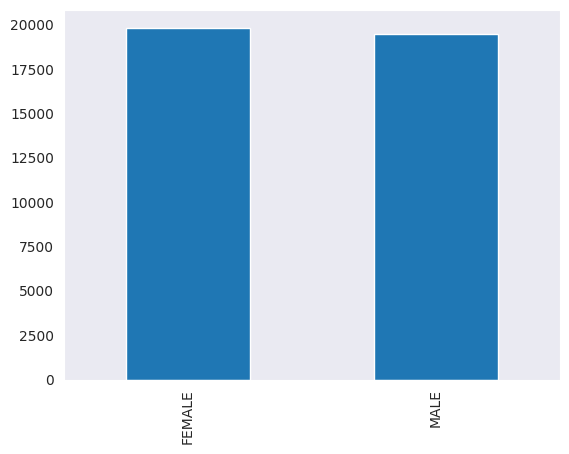

In [ ]:
print(train['GENDER'].value_counts())
train['GENDER'].value_counts().plot(kind= 'bar')

<Axes: ylabel='Frequency'>

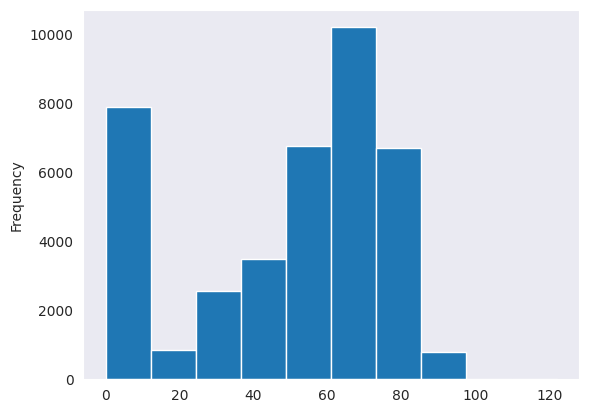

In [ ]:
train['AGE'].plot.hist()

In [ ]:
gender = [1 if x =='FEMALE' else 0 for x in gender]
set(gender)

{0, 1}

In [ ]:
stack = np.stack([np.load(x) for x in ecg_filenames[:10]])

In [ ]:
stack.shape

(10, 60000)

In [ ]:
ecg_filenames = np.array(ecg_filenames)
age = np.array(age)
gender = np.array(gender)
ecg_len = np.array(ecg_len)
labels = np.array(labels)

In [ ]:
age

array([53.        , 68.        , 59.        , ...,  0.08333333,
        2.25      ,  4.5       ])

In [ ]:
gender

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def split_data(age, gender):
    n_splits = 5
    random_state = 42
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds = list(kf.split(gender, age))

    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds

folds = split_data(age, gender)

Training split: 31437
Validation split: 7860


In [ ]:
def shuffle_batch_generator_age(batch_size, gen_x,gen_y,num_leads):
    batch_features = np.zeros((batch_size,samp_freq*time, num_leads))
    batch_labels_1 = np.zeros((batch_size,1))

    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels_1[i] = next(gen_y)

        yield batch_features, batch_labels_1

def generate_y_age(y_train):
    while True:
        for i in y_train:
            yield i


def generate_X_age(X_train):
    while True:
        for ecg_filename in X_train:
            data = load_data(ecg_filename)

            yield data


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',
    min_delta=0.0001, cooldown=2, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis=2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    x = keras.layers.Add()([shortcut_y, out_tensor])
    x = keras.layers.Activation('relu')(x)
    return x

def build_model(input_shape, nb_classes, depth=50, use_residual=True):
    input_layer = keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(units=nb_classes,activation='linear')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    #model.compile(loss=[macro_double_soft_f1], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



In [ ]:
samp_freq = 500
time = 10
num_leads = 12
batchsize = 8
epoch = 25

history = None
for i in range(len(folds)):
    train_ind = folds[i][0]
    test_ind = folds[i][1]


    #model = attia_network_age(samp_freq,time,num_leads) # velg modell
    model = build_model((samp_freq*time,num_leads), 1)
    history = model.fit(x = shuffle_batch_generator_age(batch_size=batchsize,
                                              gen_x=generate_X_age(ecg_filenames[train_ind]),
                                              gen_y=generate_y_age(age[train_ind]),
                                              num_leads=num_leads),
              epochs=epoch,
              steps_per_epoch=(len(train_ind)/batchsize),
              validation_data=shuffle_batch_generator_age(batch_size=batchsize,
                                                          gen_x=generate_X_age(ecg_filenames[test_ind]),
                                                          gen_y=generate_y_age(age[test_ind]),
                                                          num_leads=num_leads),
              validation_freq=1,
              validation_steps = (len(test_ind)/batchsize),
              verbose = 1,
              callbacks=[reduce_lr,early_stop]
              )
    mse_score = []
    mae_score = []
    f1_score = []
    acc_score = []
    pred_age = []
    true_age = []
    for j in tqdm.tqdm(test_ind):
        data = load_data(ecg_filenames[j])
        y_true = age[j]
        true_age.append(y_true)
        y_hat = model.predict(np.expand_dims(data, axis=0))
        pred_age.append(y_hat)
        mse_score.append(mean_squared_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
        mae_score.append(mean_absolute_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
    mse_score = np.asarray(mse_score).mean()
    mae_score = np.asarray(mae_score).mean()
    print("MAE score {}".format(mae_score))
    print("MSE score {}".format(mse_score))

    break


Training model...
Epoch 1/25
3929/3929 [==============================] - 3758s 923ms/step - loss: 13.1968 - mean_squared_error: 388.7119 - val_loss: 44.9270 - val_mean_squared_error: 2721.3108 - lr: 0.0010
Epoch 2/25
1319/3929 [=========>....................] - ETA: 37:38 - loss: 13.5649 - mean_squared_error: 327.1241

In [ ]:
d = {"True age": np.asarray(true_age).ravel(), 'Predicted age': np.asarray(pred_age).ravel(),'Error': abs(np.asarray(true_age).ravel() - np.asarray(pred_age).ravel())}
df = pd.DataFrame(data = d)

## Analysis:


### Predicted vs actual age - Numbers of true and predicted ages

In [ ]:
plt.figure(figsize=(30,15))
plt.hist(df["Predicted age"], bins=100, label="Predicted age", alpha=0.6)
plt.hist(df["True age"], bins=100, label="True age", alpha=0.6)
plt.legend()
plt.xlim(0,100)
plt.xlabel("Age")
plt.ylabel("Number of patients")
plt.show()

### Comparing the predicted age vs the acual age. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["True age"],df["Predicted age"])
reg_line = (np.arange(101)*slope) + intercept
plt.figure(figsize=(30,15))
sns.set(font_scale=2)
sns.scatterplot(data=df, x="True age", y="Predicted age")
sns.set(font_scale=5)
plt.plot(np.arange(101),'red', label="1x + 0")
plt.plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Comparing the predicted age vs the acual age seen as box plot. From this we can see which ages that are predicted most accurate and uncertain by the model. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
plt.figure(figsize=(30,15))
sns.set(font_scale=2)
sns.boxplot(data=df, x="True age", y="Predicted age")
plt.plot(np.arange(101),'red', label="1x + 0")
plt.plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
plt.xticks(fontsize=12)
plt.legend()
plt.xlim(0,100)
plt.show()

### Total absoulte error between real and predicted age for each year

In [ ]:
plt.figure(figsize=(30,15))
sns.barplot(x="True age", y="Error",data=df.groupby("True age").sum().reset_index())
plt.ylabel("Total absolute error pr age")
plt.xticks(fontsize=12)
plt.show()

### Mean absoulte error between real and predicted age for each year

In [ ]:
df_err = df.groupby("True age").sum().reset_index()
df_err["count"] = df.groupby("True age").count()["Error"]
df_err["count"] = df_err["count"].fillna(0)
df_err["Mean Error"] = df_err["Error"]/df_err["count"]

plt.figure(figsize=(30,15))
sns.barplot(x="True age", y="Mean Error",data=df_err)
plt.ylabel("Mean absoulte error pr age")
plt.xticks(fontsize=12)
plt.show()

In [ ]:
snomed_ct_codes = np.array(["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","164909002","251146004","698252002","426783006","284470004",
 "10370003","365413008","427172004","164947007","111975006","164917005","47665007","59118001","427393009","426177001","427084000","63593006","164934002","59931005","17338001"])


In [ ]:
diagnoses = np.array(["atrial fibrillation","atrial flutter","bundle branch block","bradycardia","complete left bundle branch block","complete right bundle branch block","1st degree av block","incomplete right bundle branch block","left axis deviation","left anterior fascicular block",
"left bundle branch block","low qrs voltages","nonspecific intraventricular conduction disorder","sinus rhythm","premature atrial contraction","pacing rhythm","poor R wave Progression","premature ventricular contractions","prolonged pr interval","prolonged qt interval",
"qwave abnormal","right axis deviation","right bundle branch block","sinus arrhythmia","sinus bradycardia","sinus tachycardia","supraventricular premature beats","t wave abnormal","t wave inversion","ventricular premature beats"])


In [ ]:
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass
    return labels

def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

In [ ]:
val_ecg_filenames =np.asarray(ecg_filenames)[test_ind]

In [ ]:
classes = set()
for ecg_file in tqdm.tqdm(val_ecg_filenames):
    header_file = ecg_file.replace('.mat','.hea')
    header = load_header(header_file)
    classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
num_classes = len(classes)

In [ ]:
scored_classes = []
for i in classes:
    for j in snomed_ct_codes:
        if i == '':
            continue
        if i == j:
            scored_classes.append(i)
scored_classes = sorted(scored_classes)

In [ ]:
class_names = []
for j in range(len(scored_classes)):
    for i in range(len(snomed_ct_codes)):
        if (str(snomed_ct_codes[i]) == scored_classes[j]):
            class_names.append(diagnoses[i])

In [ ]:
num_recordings = len(val_ecg_filenames)
num_classes = len(scored_classes)
val_labels = np.zeros((num_recordings, num_classes), dtype=np.bool) # One-hot encoding of classes

for i in range(len(val_ecg_filenames)):
    current_labels = get_labels(load_header(val_ecg_filenames[i].replace('.mat','.hea')))
    for lab in current_labels:
        if lab in scored_classes:
            j = scored_classes.index(lab)
        val_labels[i, j] = 1
val_labels = val_labels * 1

### Comparing the predicted age vs the actual age for 30 different cardiovascular diseases. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
fig, ax = plt.subplots(6, 5, sharex=True, sharey=True)
fig.set_figheight(46)
fig.set_figwidth(46)
cnt = 0
cnt_2 = 0
for i in range(30):
    TE = np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]).sum()
    MAE = np.asarray(abs(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])).sum()/len(np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"],df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])
    ax[cnt_2,cnt].set_title(class_names[i] + ", MAE= {}".format(round(MAE,2)))
    df_temp = df.iloc[np.where(val_labels[:,i]==1)[0]]
    ax[cnt_2,cnt].scatter(df_temp["True age"],df_temp["Predicted age"])
    #sns.scatterplot(data=df.iloc[np.where(val_labels[:,i]==1)[0]], x="True age", y="Predicted age")
    ax[cnt_2,cnt].plot(np.arange(101),'red', label="1x + 0")
    ax[cnt_2,cnt].plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
    ax[cnt_2,cnt].set_xlabel("True age")
    ax[cnt_2,cnt].set_ylabel("Predicted age")
    ax[cnt_2,cnt].legend()
    cnt += 1
    if cnt == 5:
        cnt_2 += 1
        cnt = 0

